In [1]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import pathlib
import pandas as pd
import numpy as np
from keras_preprocessing.image import ImageDataGenerator


In [2]:
#NOTE - I am working in an nvidia-docker image with official tensorflow docker.
# I had to add this line AND 'trust' the notebook on top-right. Otherwise an ugly
# cudNN error is present.

gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    for gpu in gpus:
        tf.config.experimental.set_memory_growth(gpu, True)

In [27]:
image_dir = '/home/jovyan/work/beetleData/pix/'
label_csv = '/home/jovyan/work/beetleData/labels.csv'

In [28]:
def make_generators(image_size,
                    top6_train,
                    top6_valid,
                    y_target):
    
    datagen=ImageDataGenerator(rescale=1./255)
    train_generator=datagen.flow_from_dataframe(dataframe=top6_train,
                                            directory=image_dir,
                                            x_col="Filename:", y_col=y_target,
                                            class_mode="categorical",
                                            target_size=image_size,
                                            batch_size=12)
    validation_generator=datagen.flow_from_dataframe(dataframe=top6_valid,
                                            directory=image_dir,
                                            x_col="Filename:", y_col= y_target,
                                            class_mode="categorical",
                                            target_size=image_size,
                                            batch_size=12)
    
    return train_generator, validation_generator

In [21]:
def make_model(input_shape, num_classes):
    inputs = keras.Input(shape=input_shape)
    # Image augmentation block
    #x = data_augmentation(inputs)

    # Entry block
    #x = layers.experimental.preprocessing.Rescaling(1.0 / 255)(inpu)
        # This is done already because we used an ImageDataGenerator
    x = layers.Conv2D(32, 3, strides=2, padding="same")(inputs)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)

    x = layers.Conv2D(64, 3, padding="same")(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)

    previous_block_activation = x  # Set aside residual

    for size in [128, 256, 512, 728]:
        x = layers.Activation("relu")(x)
        x = layers.SeparableConv2D(size, 3, padding="same")(x)
        x = layers.BatchNormalization()(x)

        x = layers.Activation("relu")(x)
        x = layers.SeparableConv2D(size, 3, padding="same")(x)
        x = layers.BatchNormalization()(x)

        x = layers.MaxPooling2D(3, strides=2, padding="same")(x)

        # Project residual
        residual = layers.Conv2D(size, 1, strides=2, padding="same")(
            previous_block_activation
        )
        x = layers.add([x, residual])  # Add back residual
        previous_block_activation = x  # Set aside next residual

    x = layers.SeparableConv2D(1024, 3, padding="same")(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)

    x = layers.GlobalAveragePooling2D()(x)
    if num_classes == 2:
        activation = "sigmoid"
        units = 1
    else:
        activation = "softmax"
        units = num_classes

    x = layers.Dropout(0.5)(x)
    outputs = layers.Dense(units, activation=activation)(x)
    return keras.Model(inputs, outputs)

In [22]:
def train_class(model,
                epochs=10,
               label_smooth=False,
               class_weights=True):
    from sklearn.utils import class_weight

    callbacks = [
        keras.callbacks.ModelCheckpoint("save_at_{epoch}.h5"),
    ]
    
    if label_smooth:
        loss = keras.losses.CategoricalCrossentropy(label_smoothing=label_smooth)
    else:
        loss = ' categorical_crossentropy'
    
    #LABEL_SMOOTHING BLOCK
    model.compile(
        optimizer=keras.optimizers.Adam(1e-3),
        loss=loss,
        metrics=["accuracy"],
)
    
    y_train = train_generator.classes
    
    
    #CLASS_WEIGHTS BLOCK
    if class_weights:
        c_weights = class_weight.compute_class_weight('balanced',
                                                     np.unique(y_train),
                                                     np.array(y_train))
        class_weight_dict = dict(enumerate(c_weights))
        
        
        
    #Fit the model - based on conditions
        history58x58 = model.fit(
            train_generator,validation_data=validation_generator,epochs=epochs
            #    train_generator,validation_data=validation_generator,epochs=epochs, callbacks=callbacks
        )
        return history58x58
    else:
        history58x58 = model.fit(
        train_generator,validation_data=validation_generator,epochs=epochs
        #    train_generator,validation_data=validation_generator,epochs=epochs, callbacks=callbacks
    )
        return history58x58

In [23]:
def csvSplitter(dataframe, split_ratio):
    """
    To use the data generator in keras with flow_from_dataset, you need a helper function to perform the train/test
    split.
    
    Input: a pandas CSV/Table of all your data.
    Output : the same dataframe, split into seperate training/validation dataframes, to be used in rest of pipeline
    """
    dataframe = dataframe.sample(frac=1).reset_index(drop=True) #Shuffles DataFrame - for a lazy way to test/train split
    validation_index = round(dataframe.shape[0] * split_ratio) # Gets row # of images in validation set 
    training_index = dataframe.shape[0] - validation_index # Gets row # of images in training set
    train_valid_split = np.concatenate((np.ones(validation_index),np.zeros(training_index))) # creates train-valid column
    dataframe['trainValid'] = train_valid_split # adds the splitting ID to the dataframe
    train_df = dataframe[dataframe['trainValid'] == 0.0] #subsetting based on previously created test/train split col
    valid_df = dataframe[dataframe['trainValid'] == 1.0]
    
    return train_df, valid_df


In [29]:
def get_beetle_labels(y_target = 'Family:',
                      data_dir = image_dir,
                      label_file = label_csv,
                      top_classes = 6):
    """
    Read label file
    Get images from Dorsal View
    Take those images and use csvsplitter
    Return train and test dataframes
    """
    labels = pd.read_csv(label_file)
    assert y_target in labels.columns, "y_target should be a column in the label_file!"
    
    data_dir = pathlib.Path('/tf/beetleData/images/')
    dorsal_data = labels[labels["View:"] == "Dorsal"] #filter images that are from dorsal view
    dorsal_data[y_target].value_counts().sort_values().plot(kind = 'barh') # preview the distribution
    
    top6 = dorsal_data[y_target].value_counts(normalize=True)[:top_classes]
    print(top6)
    print('c1' + str(top6.shape))
    top6 = top6.index.values # get top 6 most common classes.
    top6_df = dorsal_data[dorsal_data[y_target].isin(top6)] #filter images from only top 6 classes
    top6_train, top6_valid = csvSplitter(top6_df, .2)
    #print(top6_train[y_target])
    #print(top6_valid[y_target])
    #failsafe -> make sure that no unique labels are exclusive to training or validation set
    overlap_labels = (list(set(top6_train[y_target]) & set(top6_valid[y_target])))
    top6_train = top6_train.loc[top6_train[y_target].isin(overlap_labels)]
    print(top6_valid.shape)
    top6_valid = top6_valid.loc[top6_valid[y_target].isin(overlap_labels)]
    print(top6_valid.shape)
    
    #Add a failsafe - > make sure no unique target labels are exclusively in training or validation
    print('loaded in training size of ' + str(top6_train.shape))
    
    return top6_train, top6_valid

In [30]:
def train_all(epochs=10,
              y_target ='Family:',
              image_size = (100,100),
              top_classes=5,
             label_smooth=False):
    
    #y_target='Genus:'
    #top_classes = 25 # attempts to get 100 classes. but may be less if the labels are exclusive to test/valid
    #epochs = 10
    tr, va = get_beetle_labels(y_target=y_target,
                              top_classes=top_classes) # top classes has to be oddly high (for any label
                                                # other than the family label, unsure why

    #np.sort(va['Species:'].unique()) == np.sort(tr['Species:'].unique())
    train_generator,  validation_generator  = make_generators(image_size, tr, va,y_target)
    num_classes = len(np.unique(train_generator.classes))
    model = make_model(input_shape=image_size + (3,), num_classes=num_classes)
    history = train_class(model, epochs=epochs,label_smooth=label_smooth)
              


In [31]:
train_all(epochs=5)

AssertionError: y_target should be a column in the label_file!

In [32]:
def do_all():

    
    y_target='Species:'
    top_classes = 5 # attempts to get 100 classes. but may be less if the labels are exclusive to test/valid
    epochs = 5
    label_smooth=0.1
    image_size=(58,58)
    
    tr, va = get_beetle_labels(y_target=y_target,
                          top_classes=top_classes) #attempts to make a valid/train split w/ # of top_classes
    
  

    assert sum(np.sort(va[y_target].unique()) == np.sort(tr[y_target].unique())) == len(va[y_target].unique()), \
    'Mismatched Labels?'
    
    train_generator,  validation_generator  = make_generators(image_size, tr, va,y_target)
    num_classes = len(np.unique(train_generator.classes))
    model = make_model(input_shape=image_size + (3,), num_classes=num_classes)
    history = train_class(model, epochs=epochs,label_smooth=label_smooth)


In [18]:
do_all()

FileNotFoundError: [Errno 2] No such file or directory: '/tf/beetleData/labels/master_rbi.csv'

In [19]:
y_target='Family:'
top_classes = 5 # attempts to get 100 classes. but may be less if the labels are exclusive to test/valid
epochs = 5
label_smooth=0.05
image_size=(58,58)

tr, va = get_beetle_labels(y_target=y_target,
                      top_classes=top_classes) # top classes has to be oddly high (for any label
                                        # other than the family label, unsure why

assert sum(np.sort(va[y_target].unique()) == np.sort(tr[y_target].unique())) == len(va[y_target].unique()), \
    'Mismatched Labels?'
train_generator,  validation_generator  = make_generators(image_size, tr, va,y_target)
num_classes = len(np.unique(train_generator.classes))
model = make_model(input_shape=image_size + (3,), num_classes=num_classes)
history = train_class(model, epochs=epochs,label_smooth=label_smooth)

FileNotFoundError: [Errno 2] No such file or directory: '/tf/beetleData/labels/master_rbi.csv'

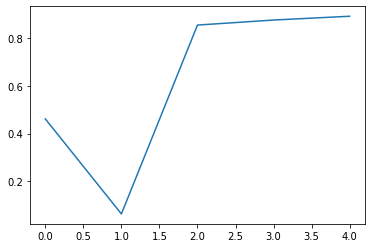

In [15]:
pd.DataFrame(history.history)['val_accuracy'].plot()